In [1]:
source('utilities.R')
library(tidyr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Package 'mclust' version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.


Attaching package: ‘purrr’


The following object is masked from ‘package:mclust’:

    map


Loading required package: future



In [2]:
tz <- "US/Pacific"
refit_starts <- as.Date('2019-01-07',tz=tz)
#refit_ends <- as.Date('2019-09-29',tz=tz)
refit_ends <- as.Date('2019-11-10',tz=tz)
horizon <- 14
n_sim <- 100
step = 15

In [3]:
models <- readRDS(paste0('models/models_',as.character(refit_ends),'.rds'))

In [4]:
df <- read.csv("../Data/palo_alto.csv")

### 1. SARIMA

In [5]:
all_sess <- sessions(df = df,train_starts = refit_starts,train_ends = as.Date(max(df$Start),tz=tz),tz = "US/Pacific")

In [6]:
sess <- sessions(df = df,train_starts = refit_starts,train_ends = refit_ends,tz = "US/Pacific")

In [7]:
sarima_sim <- sarima_simulate(fit = models[[1]], sess = sess, horizon = horizon, n_sim = n_sim)

[1] "===== SARIMA simulation ====="
Time difference of 9.790423 secs


In [8]:
simulations <- sarima_sim[[1]]
quantile_forecasts <- sarima_sim[[2]]

In [9]:
X_0 <- all_sess %>% filter(Start_Date > refit_ends,Start_Date <= refit_ends + horizon) %>% pull(sessions)

In [10]:
library(tidyr)
sim_long <- simulations %>% 
    mutate(X0 = X_0) %>%
    pivot_longer(cols = starts_with("X"), names_to = "Series", values_to = "Value")

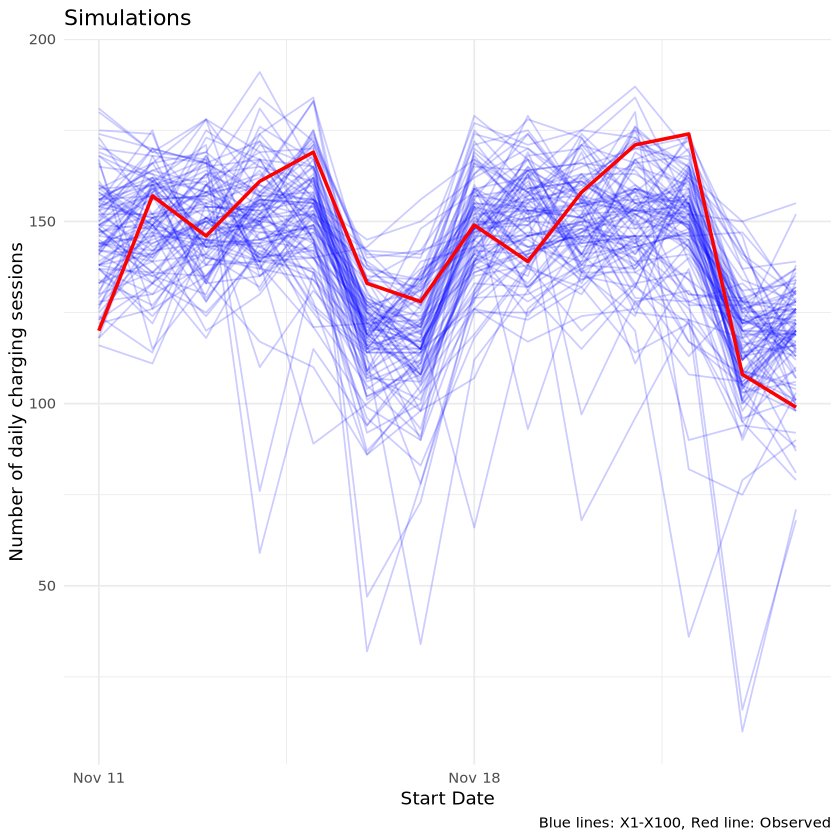

In [11]:
ggplot(data = sim_long %>% filter(Series != "X0"), aes(x = Start_Date, y = Value, group = Series)) +
  geom_line(alpha = 0.2, color = "blue") +  # Transparent blue lines for X1 to X100
  geom_line(
    data = sim_long %>% filter(Series == "X0"),
    aes(x = Start_Date, y = Value),  # Use Value here, since it's the column holding the values
    color = "red", linewidth = 1
  ) +
  labs(
    title = "Simulations",
    x = "Start Date",
    y = "Number of daily charging sessions",
    caption = "Blue lines: X1-X100, Red line: Observed"
  ) +
  theme_minimal()

### 2. GMM

In [12]:
#gmm_sim <- gmm_simulate(gmm = models[[2]], quantile_forecasts = quantile_forecasts,n_simu = 1000)
gmm_sim <- gmm_simulate(gmm = models[[2]], quantile_forecasts = simulations,n_simu = 100)

[1] "===== GMM simulation ====="
Time difference of 14.22988 mins


### 3. Profile Reconstruction

In [13]:
# All

In [14]:
df <- read.csv('../Data/palo_alto.csv')
tz = "US/Pacific"

all_trans <- transactions(df = df,train_starts = refit_ends+1,train_ends = refit_ends+14,tz = tz)
real_profile <- load_profile(all_trans,step,tz=tz)

In [15]:
print("===== Profiles reconstruction =====")
time_start <- Sys.time()
plan(multisession)
profiles <- flatten(gmm_sim) %>%
  future_map_dfr(load_profile, step=step)
plan(sequential)
print(Sys.time() - time_start)

### 4. Load Quantiles
final <- profiles %>%
group_by(Start) %>%
summarise(
  mean = mean(Power),
  q10 = quantile(Power, 0.10, type=1),
  q20 = quantile(Power, 0.20, type=1),
  q30 = quantile(Power, 0.30, type=1),
  q40 = quantile(Power, 0.40, type=1),
  q50 = quantile(Power, 0.50, type=1),
  q60 = quantile(Power, 0.60, type=1),
  q70 = quantile(Power, 0.70, type=1),
  q80 = quantile(Power, 0.80, type=1),
  q90 = quantile(Power, 0.90, type=1)
)

[1] "===== Profiles reconstruction ====="
Time difference of 1.851664 mins


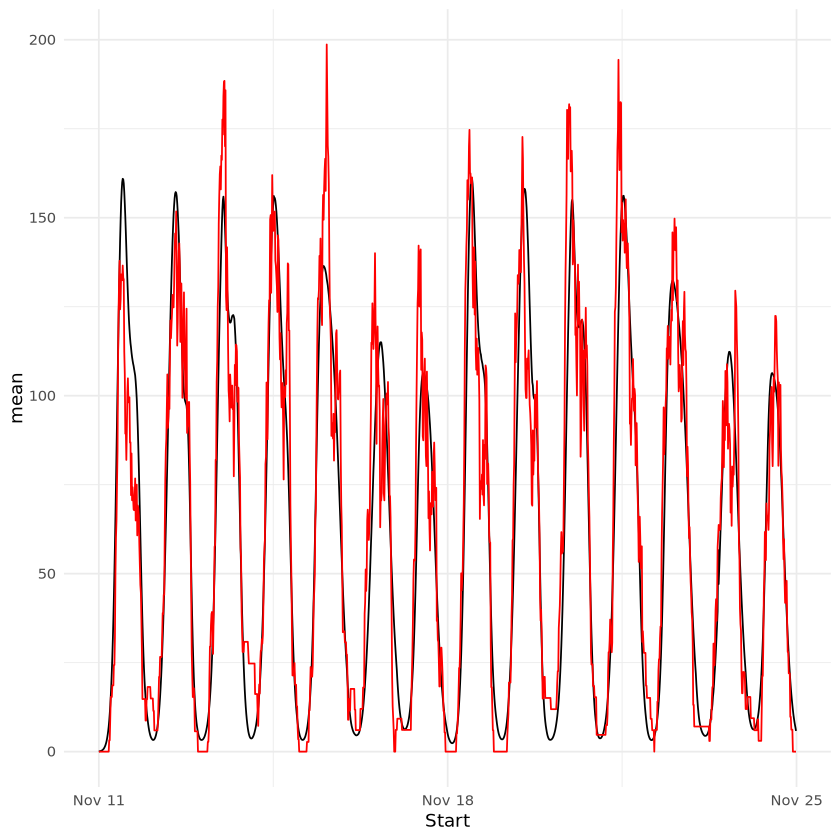

In [16]:
ggplot(data = final, aes(x=Start,y=mean)) +
    geom_line() +
    geom_line(data=real_profile, aes(y=Power), col='red') +
    theme_minimal()

In [17]:
rmse(final$mean,real_profile$Power)
mae(final$mean,real_profile$Power)
nmae(final$mean,real_profile$Power)
mean(final$mean-real_profile$Power)

[1] 18.53397

[1] 3.651942

[1] 5.93

[1] -1.293796

In [18]:
#saveRDS(gmm_sim,'../Outputs/transactions.rds')

### END